In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
    # Assuming your CSV is named 'covid_19_clean_complete.csv' and is in your Colab environment
    # You might need to upload it or mount Google Drive
df = pd.read_csv('/content/drive/MyDrive/covid_19_clean_complete/covid_19_clean_complete.csv', parse_dates=['Date'])

    # Filter for a specific country (e.g., 'US')
    country_df = df[df['Country/Region'] == 'US'].copy()

    # Aggregate confirmed cases by date for the country
    daily_cases = country_df.groupby('Date')['Confirmed'].sum().reset_index()
    daily_cases.set_index('Date', inplace=True)

    # Resample to daily frequency (if there are missing dates) and fill NaNs
    daily_cases = daily_cases.asfreq('D', fill_value=0)

    # Calculate daily new confirmed cases (if 'Confirmed' is cumulative)
    daily_cases['New_Confirmed'] = daily_cases['Confirmed'].diff().fillna(0)
    daily_cases['New_Confirmed'] = daily_cases['New_Confirmed'].apply(lambda x: max(0, x)) # Ensure no negative values

    # Select the series for modeling
    ts = daily_cases['New_Confirmed']

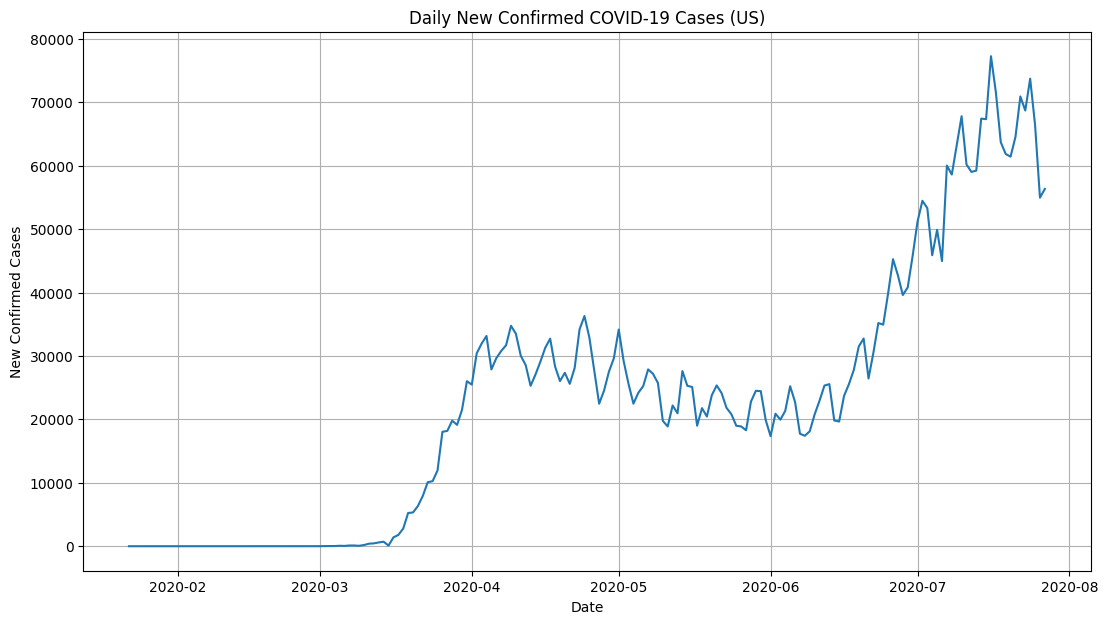

In [ ]:
    plt.figure(figsize=(13, 7))
    plt.plot(ts)
    plt.title('Daily New Confirmed COVID-19 Cases (US)')
    plt.xlabel('Date')
    plt.ylabel('New Confirmed Cases')
    plt.grid(True)
    plt.show()


In [ ]:
    from statsmodels.tsa.stattools import adfuller

    def adf_test(series):
        result = adfuller(series, autolag='AIC')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        if result[1] <= 0.05:
            print("Series is stationary (reject H0)")
        else:
            print("Series is non-stationary (fail to reject H0)")

    print("ADF Test for Original Series:")
    adf_test(ts)

    # If non-stationary, apply differencing
    ts_diff = ts.diff().dropna()
    print("\nADF Test for Differenced Series:")
    adf_test(ts_diff)


ADF Test for Original Series:
ADF Statistic: -1.4979351177033127
p-value: 0.5345325582285283
Critical Values:
   1%: -3.468952197801766
   5%: -2.878495056473015
   10%: -2.57580913601947
Series is non-stationary (fail to reject H0)

ADF Test for Differenced Series:
ADF Statistic: -2.800370524520788
p-value: 0.05822086076742732
Critical Values:
   1%: -3.4691814633722453
   5%: -2.878595143532943
   10%: -2.5758625549741803
Series is non-stationary (fail to reject H0)


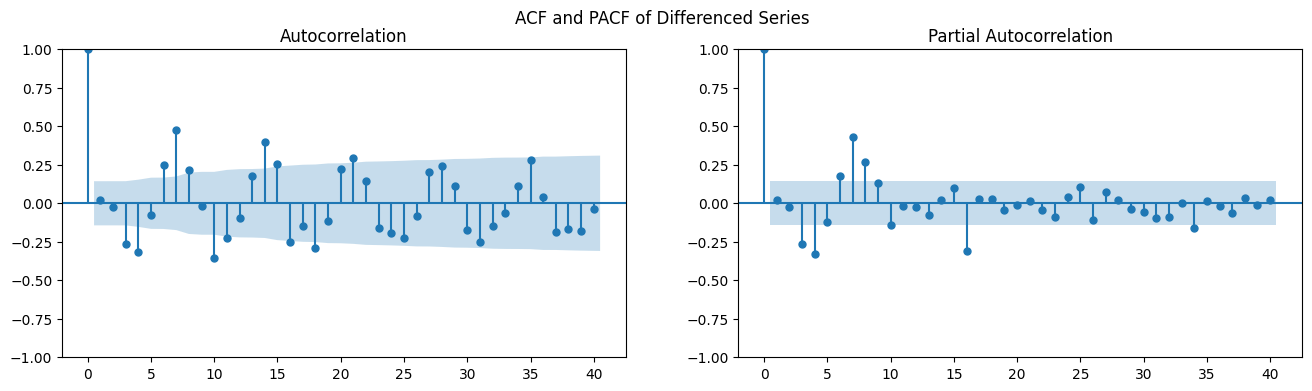

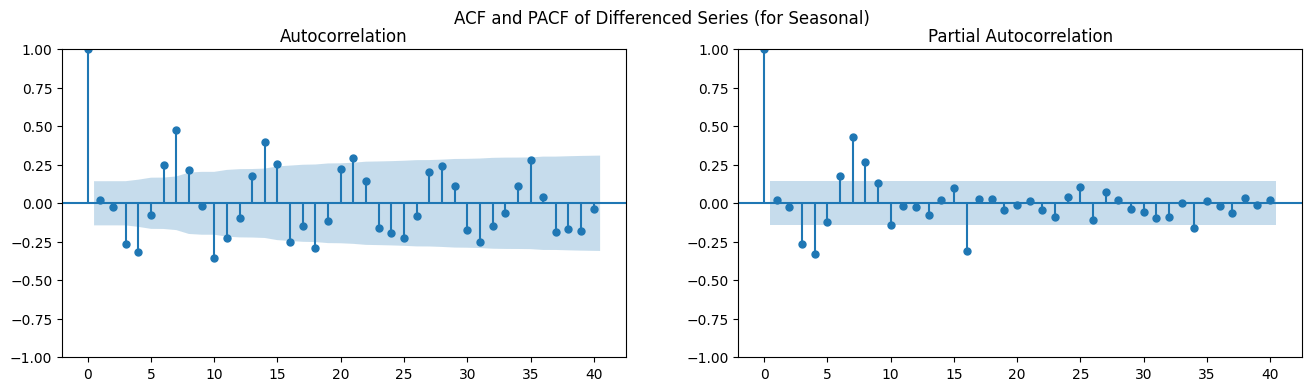

In [ ]:
    # For non-seasonal components (p, q)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(ts_diff, ax=axes[0], lags=40)
    plot_pacf(ts_diff, ax=axes[1], lags=40)
    plt.suptitle('ACF and PACF of Differenced Series')
    plt.show()

    # For seasonal components (P, Q, S) - assuming weekly seasonality (S=7)
    # Look at lags at multiples of S (e.g., 7, 14, 21)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(ts_diff, ax=axes[0], lags=40) # Look at lag 7, 14, 21 etc.
    plot_pacf(ts_diff, ax=axes[1], lags=40) # Look at lag 7, 14, 21 etc.
    plt.suptitle('ACF and PACF of Differenced Series (for Seasonal)')
    plt.show()


In [ ]:
    # Split data into training and testing sets
    train_size = int(len(ts) * 0.8)
    train, test = ts[0:train_size], ts[train_size:]

    # Define SARIMAX model parameters (example values, tune based on EDA)
    # (p, d, q) for non-seasonal, (P, D, Q, S) for seasonal
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 7) # S=7 for weekly seasonality

    # Initialize and fit the SARIMAX model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    print(model_fit.summary())

    # Make predictions
    start_index = len(train)
    end_index = len(ts) - 1
    predictions = model_fit.predict(start=start_index, end=end_index, dynamic=False) # dynamic=False for one-step-ahead forecasts


                                     SARIMAX Results                                     
Dep. Variable:                     New_Confirmed   No. Observations:                  150
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1191.150
Date:                           Fri, 15 Aug 2025   AIC                           2392.301
Time:                                   05:53:25   BIC                           2406.752
Sample:                               01-22-2020   HQIC                          2398.173
                                    - 06-19-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4205      0.326     -1.290      0.197      -1.060       0.219
ma.L1          0.1649      0.356      0.463

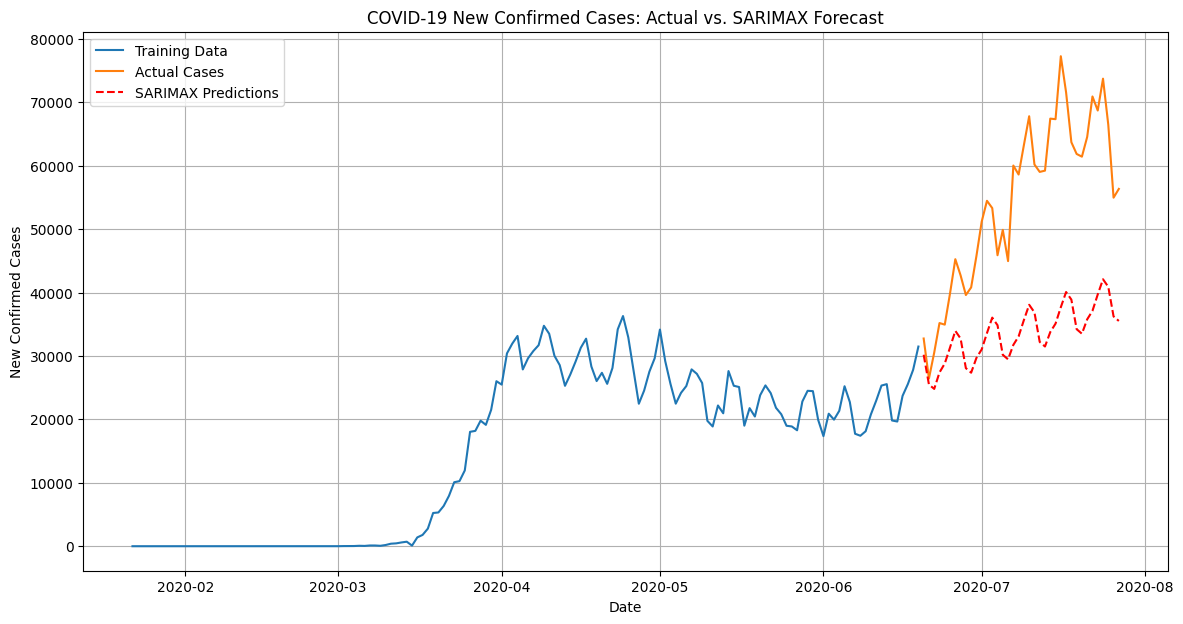

In [ ]:
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual Cases')
    plt.plot(predictions.index, predictions, label='SARIMAX Predictions', color='red', linestyle='--')
    plt.title('COVID-19 New Confirmed Cases: Actual vs. SARIMAX Forecast')
    plt.xlabel('Date')
    plt.ylabel('New Confirmed Cases')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 23033.627


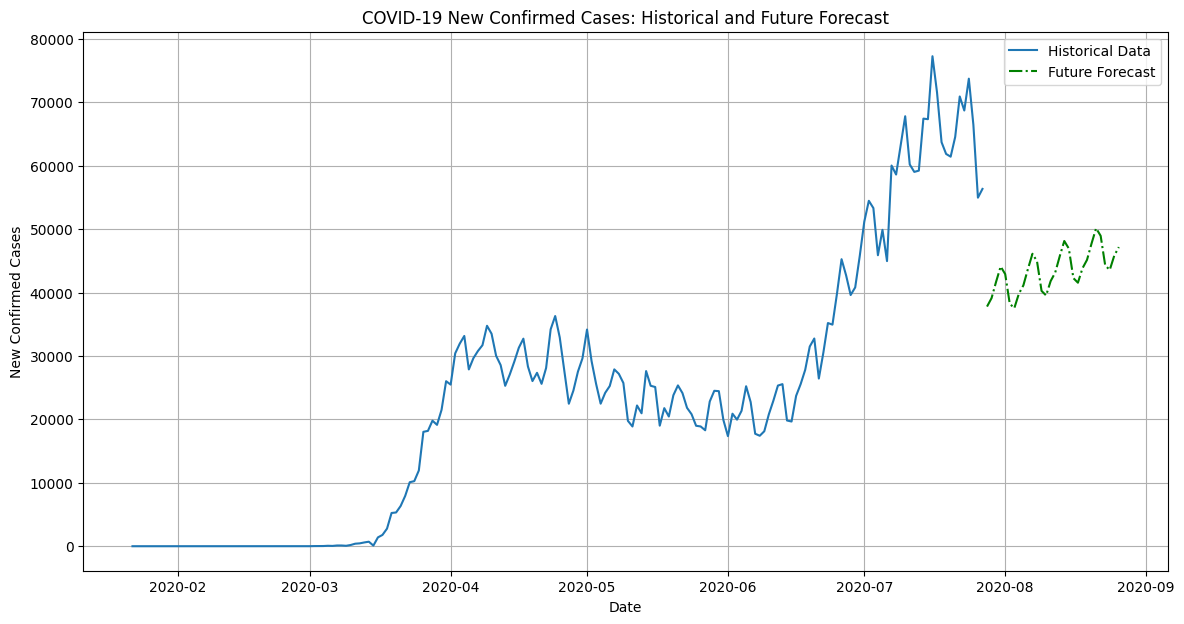

In [ ]:
    forecast_steps = 30 # Forecast for the next 30 days
    forecast = model_fit.predict(start=len(ts), end=len(ts) + forecast_steps - 1)

    # Create a date range for the forecast
    last_date = ts.index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast, index=forecast_dates)

    plt.figure(figsize=(14, 7))
    plt.plot(ts.index, ts, label='Historical Data')
    plt.plot(forecast_series.index, forecast_series, label='Future Forecast', color='green', linestyle='-.')
    plt.title('COVID-19 New Confirmed Cases: Historical and Future Forecast')
    plt.xlabel('Date')
    plt.ylabel('New Confirmed Cases')
    plt.legend()
    plt.grid(True)
    plt.show()


                                     SARIMAX Results                                     
Dep. Variable:                     New_Confirmed   No. Observations:                  150
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1187.768
Date:                           Fri, 15 Aug 2025   AIC                           2389.536
Time:                                   05:53:26   BIC                           2409.768
Sample:                               01-22-2020   HQIC                          2397.757
                                    - 06-19-2020                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
mobility_index        5.5460      4.978      1.114      0.265      -4.212      15.304
policy_stringency    9

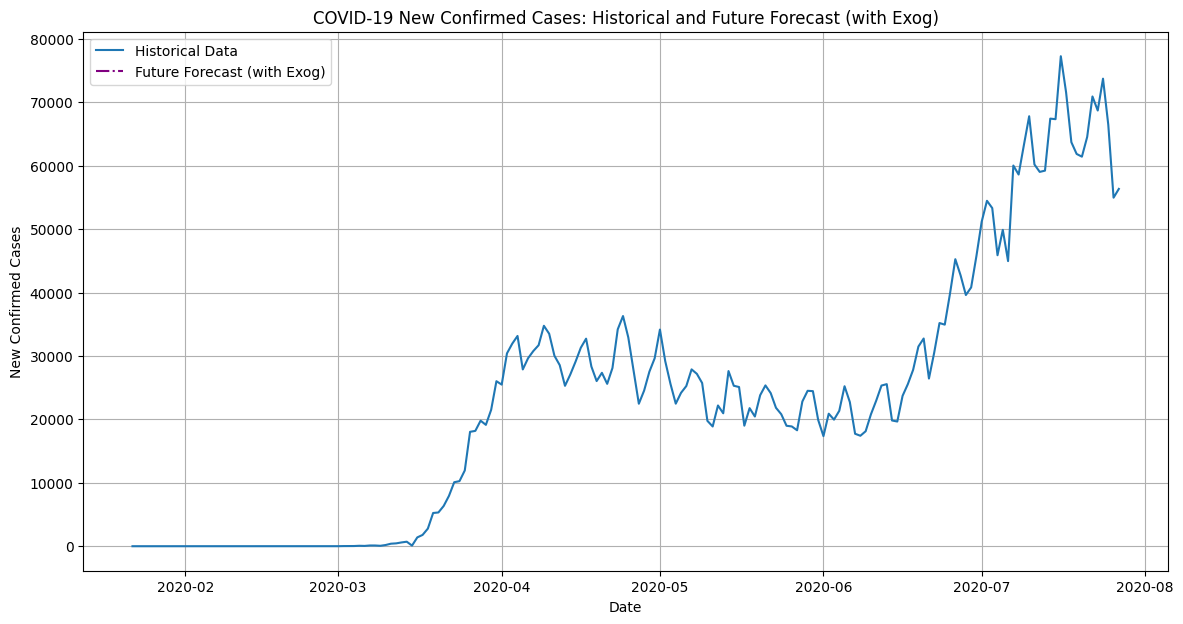

In [ ]:
# Example: Create a dummy exogenous variable (replace with real data)
# This is just for demonstration. You'd load actual data.
exog_data = pd.DataFrame(index=daily_cases.index)
exog_data['mobility_index'] = np.random.rand(len(daily_cases)) * 100 # Dummy data
exog_data['policy_stringency'] = np.random.rand(len(daily_cases)) * 10 # Dummy data

# Align exogenous data with train/test split
train_exog = exog_data.loc[train.index]
test_exog = exog_data.loc[test.index]

# Define the number of forecast steps
forecast_steps = 30

# Create a date range for the forecast
last_date = ts.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Create dummy future exogenous variables for the forecast period
# This DataFrame should have 'forecast_steps' rows
future_exog = pd.DataFrame(np.random.rand(forecast_steps, exog_data.shape[1]) * 100,
                           index=forecast_dates, columns=exog_data.columns) # Dummy future exog

# Concatenate test_exog and future_exog for forecasting
# The combined exogenous data should cover the period from the start of the test set
# to the end of the forecast period.
combined_exog_forecast = pd.concat([test_exog, future_exog])

# Re-fit the model with exogenous variables
model_exog = SARIMAX(train, exog=train_exog, order=order, seasonal_order=seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
model_exog_fit = model_exog.fit(disp=False)
print(model_exog_fit.summary())

# Make predictions on the test set with exogenous variables
# The start and end indices are relative to the training data
start_index_test = len(train)
end_index_test = len(ts) - 1
predictions_exog = model_exog_fit.predict(start=start_index_test, end=end_index_test, exog=test_exog, dynamic=False)
rmse_exog = sqrt(mean_squared_error(test, predictions_exog))
print(f'Test RMSE with Exog: {rmse_exog:.3f}')

# Forecast future values with future exogenous variables
# The start and end indices are relative to the combined exogenous data used for forecasting.
# The forecast period starts right after the training data ends (len(ts) in the original series),
# which corresponds to the start of the test data (index 0 of test_exog or combined_exog_forecast).
# The forecast itself starts after the test data ends.
start_index_forecast = len(test) # Start of forecast in combined_exog_forecast
end_index_forecast = len(combined_exog_forecast) - 1 # End of forecast in combined_exog_forecast

forecast_exog = model_exog_fit.predict(start=start_index_forecast, end=end_index_forecast, exog=combined_exog_forecast)
forecast_series_exog = pd.Series(forecast_exog, index=forecast_dates)

plt.figure(figsize=(14, 7))
plt.plot(ts.index, ts, label='Historical Data')
plt.plot(forecast_series_exog.index, forecast_series_exog, label='Future Forecast (with Exog)', color='purple', linestyle='-.')
plt.title('COVID-19 New Confirmed Cases: Historical and Future Forecast (with Exog)')
plt.xlabel('Date')
plt.ylabel('New Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/covid_19_clean_complete/covid_19_clean_complete.csv', parse_dates=['Date'])



In [ ]:
# Display basic information
print("Dataset Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  14664 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB

First 5 rows:
  Province/State Country/Region       Lat       Long       Date  Confirmed  \
0            NaN    Afghanistan  33.93911  67.709953 2020-01-22          0   
1

In [ ]:
# Aggregate confirmed cases globally per day
daily_confirmed = df.groupby('Date')['Confirmed'].sum().reset_index()
daily_confirmed.set_index('Date', inplace=True)

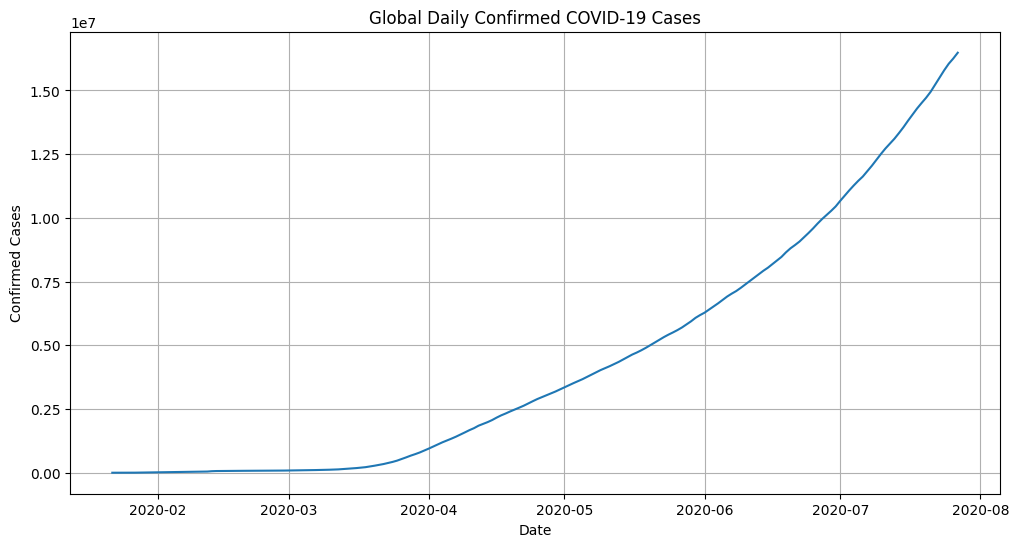

In [ ]:
# Plot daily confirmed cases
plt.figure(figsize=(12, 6))
plt.plot(daily_confirmed.index, daily_confirmed['Confirmed'])
plt.title('Global Daily Confirmed COVID-19 Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.grid(True)
plt.show()

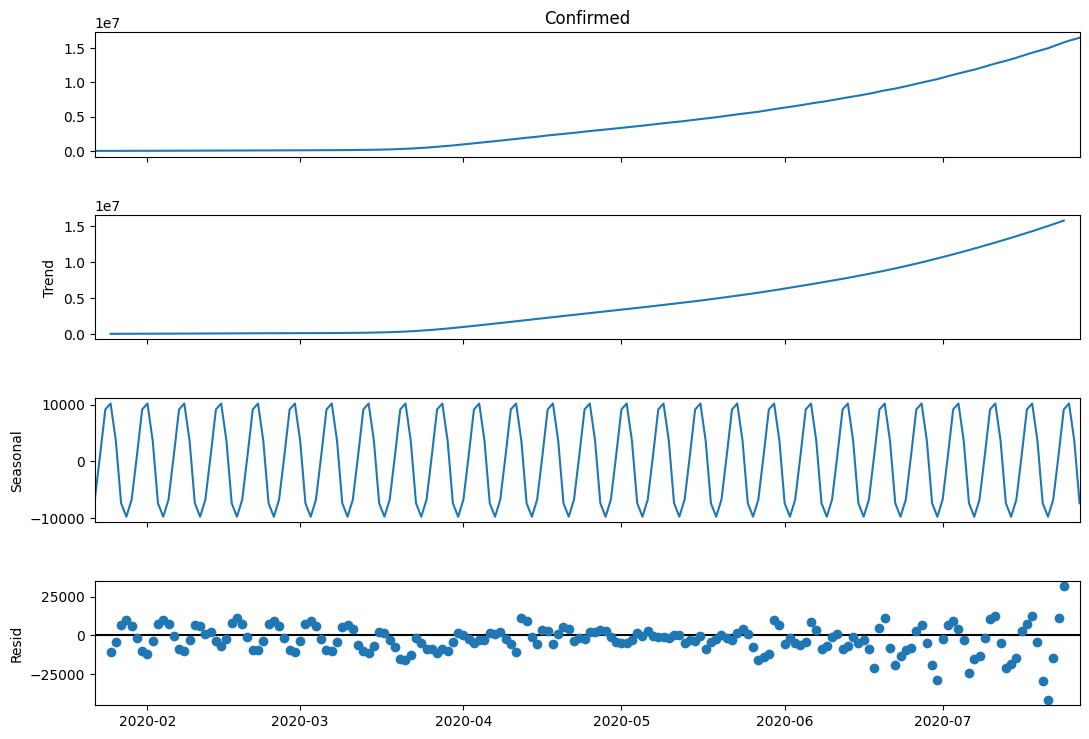

In [ ]:
# Decompose the time series to observe trends and seasonality
# We need to ensure the frequency is set if it's not inferred correctly.
# For daily data, 'D' is appropriate.
decomposition = seasonal_decompose(daily_confirmed['Confirmed'], model='additive', period=7) # Assuming weekly seasonality
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [ ]:
# Split data into training and testing sets
train_size = int(len(daily_confirmed) * 0.8)
train_data, test_data = daily_confirmed[0:train_size], daily_confirmed[train_size:]

# Fit ARIMA model
# (p, d, q) order: (AR order, differencing order, MA order)
# These parameters often require tuning. For demonstration, we'll pick some common values.
# You might need to use ACF/PACF plots or auto_arima for better parameter selection.
order = (5, 1, 0) # Example order, needs to be tuned for optimal performance
model = ARIMA(train_data['Confirmed'], order=order)
model_fit = model.fit()

print("\nARIMA Model Summary:")
print(model_fit.summary())

# Make predictions
start_index = len(train_data)
end_index = len(daily_confirmed) - 1
predictions = model_fit.predict(start=start_index, end=end_index, typ='levels')



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  150
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1554.831
Date:                Fri, 15 Aug 2025   AIC                           3121.661
Time:                        05:53:29   BIC                           3139.685
Sample:                    01-22-2020   HQIC                          3128.984
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8362      0.067     12.558      0.000       0.706       0.967
ar.L2         -0.0831      0.097     -0.855      0.393      -0.274       0.107
ar.L3          0.1340      0.0


RMSE: 772716.39
MAPE: 3.87%


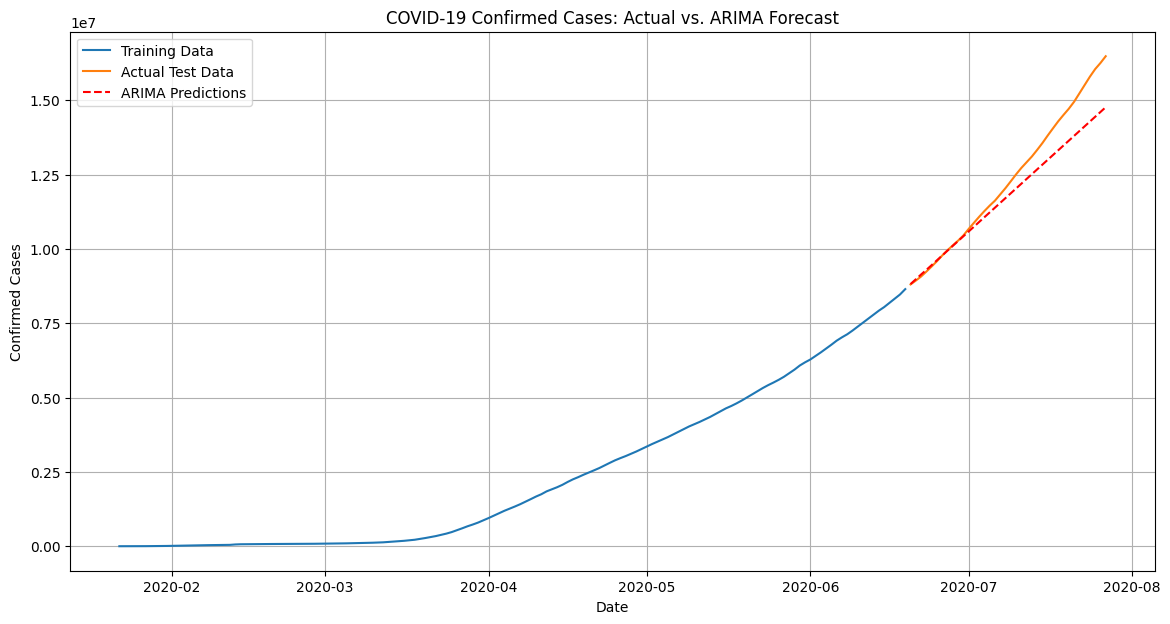

In [ ]:
# Evaluate the model
rmse = sqrt(mean_squared_error(test_data['Confirmed'], predictions))
mape = mean_absolute_percentage_error(test_data['Confirmed'], predictions) * 100

print(f"\nRMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Visualize actual vs. predicted
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Confirmed'], label='Training Data')
plt.plot(test_data.index, test_data['Confirmed'], label='Actual Test Data')
plt.plot(predictions.index, predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.title('COVID-19 Confirmed Cases: Actual vs. ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()


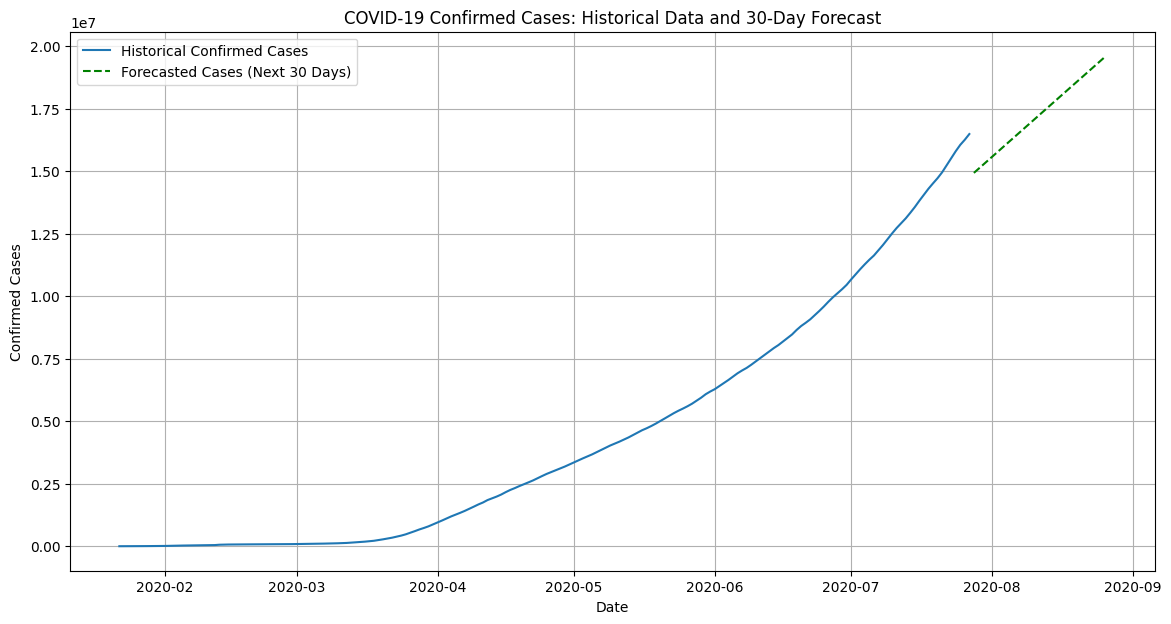


Future Forecasted Confirmed Cases:
2020-07-28    1.492628e+07
2020-07-29    1.508715e+07
2020-07-30    1.524801e+07
2020-07-31    1.540887e+07
2020-08-01    1.556973e+07
2020-08-02    1.573059e+07
2020-08-03    1.589145e+07
2020-08-04    1.605231e+07
2020-08-05    1.621317e+07
2020-08-06    1.637403e+07
2020-08-07    1.653489e+07
2020-08-08    1.669575e+07
2020-08-09    1.685661e+07
2020-08-10    1.701747e+07
2020-08-11    1.717833e+07
2020-08-12    1.733919e+07
2020-08-13    1.750005e+07
2020-08-14    1.766091e+07
2020-08-15    1.782177e+07
2020-08-16    1.798263e+07
2020-08-17    1.814349e+07
2020-08-18    1.830435e+07
2020-08-19    1.846521e+07
2020-08-20    1.862606e+07
2020-08-21    1.878692e+07
2020-08-22    1.894778e+07
2020-08-23    1.910864e+07
2020-08-24    1.926950e+07
2020-08-25    1.943035e+07
2020-08-26    1.959121e+07
Freq: D, dtype: float64


In [ ]:
# Forecast into the future (e.g., next 30 days)
future_steps = 30
forecast = model_fit.predict(start=len(daily_confirmed), end=len(daily_confirmed) + future_steps - 1, typ='levels')

# Create a date range for the forecast
last_date = daily_confirmed.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')
forecast_series = pd.Series(forecast.values, index=forecast_dates)

# Visualize the historical data and future forecast
plt.figure(figsize=(14, 7))
plt.plot(daily_confirmed.index, daily_confirmed['Confirmed'], label='Historical Confirmed Cases')
plt.plot(forecast_series.index, forecast_series, label=f'Forecasted Cases (Next {future_steps} Days)', color='green', linestyle='--')
plt.title(f'COVID-19 Confirmed Cases: Historical Data and {future_steps}-Day Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)
plt.show()

print("\nFuture Forecasted Confirmed Cases:")
print(forecast_series)


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  14664 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


,0
Province/State,34404
Country/Region,0
Lat,0
Long,0
Date,0
Confirmed,0
Deaths,0
Recovered,0
Active,0
WHO Region,0


In [ ]:
df['Province/State'].fillna('NA', inplace=True)

In [ ]:
full_grouped = df.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

In [ ]:
full_grouped['Active'] = full_grouped['Confirmed'] - full_grouped['Deaths'] - full_grouped['Recovered']

In [ ]:
china_df = full_grouped[full_grouped['Country/Region'] == 'China']
china_df = china_df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

In [ ]:
china_df = china_df.set_index('Date')
china_df.index = pd.to_datetime(china_df.index)

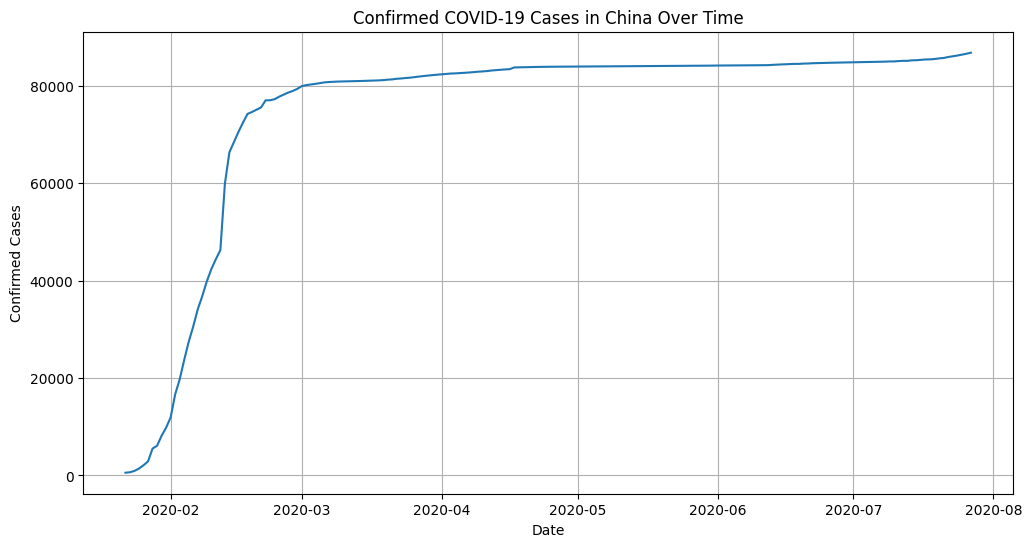

In [ ]:
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))
    plt.plot(china_df['Confirmed'])
    plt.title('Confirmed COVID-19 Cases in China Over Time')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.grid(True)
    plt.show()


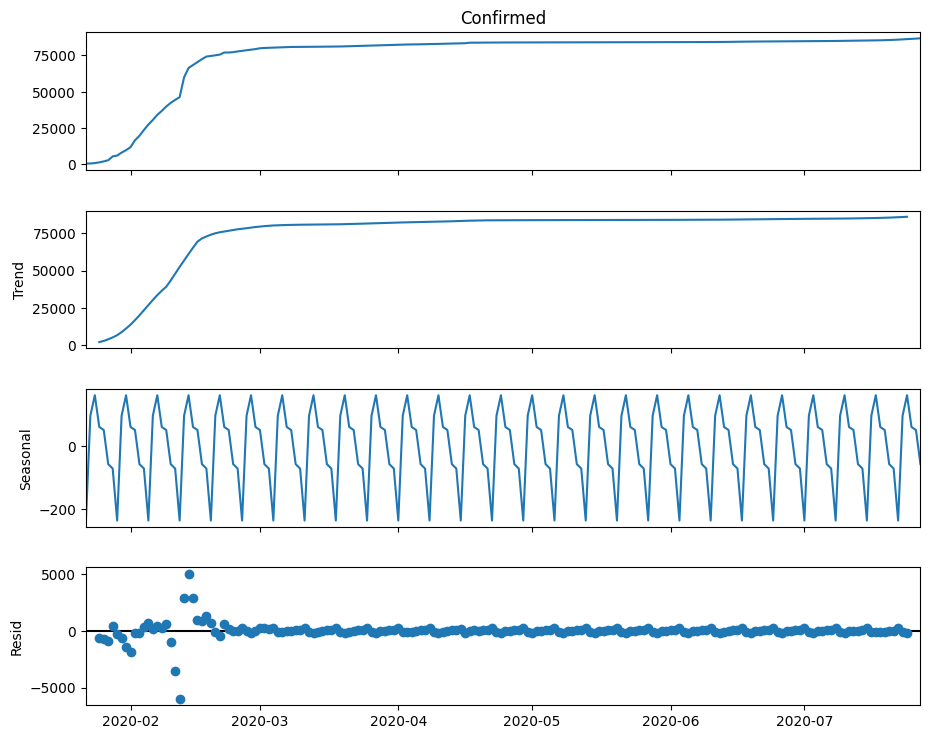

In [ ]:
    from statsmodels.tsa.seasonal import seasonal_decompose

    # For Confirmed cases
    decomposition = seasonal_decompose(china_df['Confirmed'], model='additive', period=7) # Assuming weekly seasonality
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.show()


In [ ]:
    from statsmodels.tsa.stattools import adfuller

    def adf_test(series):
        result = adfuller(series, autolag='AIC')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        for key, value in result[4].items():
            print(f'Critical Value ({key}): {value}')

    print("ADF Test for Confirmed Cases:")
    adf_test(china_df['Confirmed'])


ADF Test for Confirmed Cases:
ADF Statistic: -5.197847321928547
p-value: 8.88149188606753e-06
Critical Value (1%): -3.4662005731940853
Critical Value (5%): -2.8772932777920364
Critical Value (10%): -2.575167750182615


In [ ]:
china_df['Confirmed_diff'] = china_df['Confirmed'].diff() # Keep NaN here for now
print("\nADF Test for Differenced Confirmed Cases:")
adf_test(china_df['Confirmed_diff'].dropna()) # Apply dropna here when passing to the function


ADF Test for Differenced Confirmed Cases:
ADF Statistic: -2.435708540563807
p-value: 0.13191047792741029
Critical Value (1%): -3.4682803641749267
Critical Value (5%): -2.8782017240816327
Critical Value (10%): -2.5756525795918366


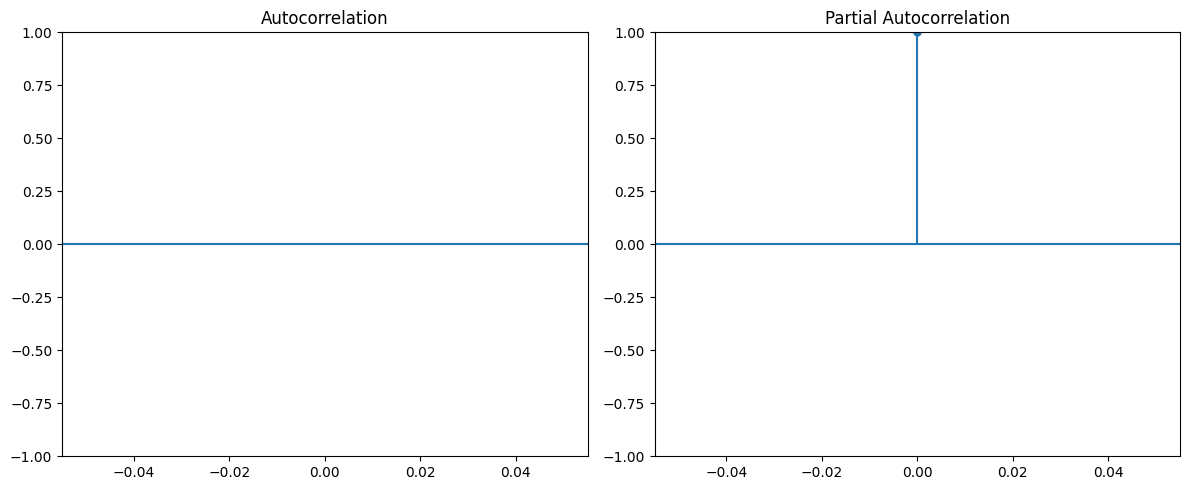

In [ ]:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

    plt.figure(figsize=(12, 5))
    plot_acf(china_df['Confirmed_diff'], lags=30, ax=plt.subplot(121))
    plot_pacf(china_df['Confirmed_diff'], lags=30, ax=plt.subplot(122))
    plt.tight_layout()
    plt.show()


In [ ]:
    from statsmodels.tsa.arima.model import ARIMA

    # (p,d,q) order
    # d is the differencing order, which is 1 if we differenced once
    arima_model = ARIMA(china_df['Confirmed'], order=(1, 1, 1))
    arima_results = arima_model.fit()
    print(arima_results.summary())


                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                  188
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1556.009
Date:                Fri, 15 Aug 2025   AIC                           3118.018
Time:                        05:53:30   BIC                           3127.711
Sample:                    01-22-2020   HQIC                          3121.946
                         - 07-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9343      0.027     34.132      0.000       0.881       0.988
ma.L1         -0.5713      0.072     -7.918      0.000      -0.713      -0.430
sigma2      9.868e+05   3.05e+04     32.309      0.0

In [ ]:
arima_forecast = arima_results.predict(start=len(china_df), end=len(china_df) + 30) # Forecast for next 30 days

In [ ]:
    # Example: Seasonal order (P, D, Q, S) = (1, 1, 1, 7)
    # P, D, Q are seasonal AR, I, MA orders. S is the seasonal period.
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    sarimax_model = SARIMAX(china_df['Confirmed'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarimax_results = sarimax_model.fit()
    print(sarimax_results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                         Confirmed   No. Observations:                  188
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1506.393
Date:                           Fri, 15 Aug 2025   AIC                           3022.786
Time:                                   05:53:32   BIC                           3038.751
Sample:                               01-22-2020   HQIC                          3029.259
                                    - 07-27-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9221      0.047     19.429      0.000       0.829       1.015
ma.L1         -0.5501      0.088     -6.278

In [ ]:
sarimax_forecast = sarimax_results.predict(start=len(china_df), end=len(china_df) + 30)

In [ ]:
train_size = int(len(china_df) * 0.8)
train_data, test_data = china_df['Confirmed'].iloc[:train_size], china_df['Confirmed'].iloc[train_size:]

In [ ]:
arima_train_model = ARIMA(train_data, order=(1, 1, 1))
arima_train_results = arima_train_model.fit()
arima_test_predictions = arima_train_results.predict(start=len(train_data), end=len(china_df)-1)

sarimax_train_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarimax_train_results = sarimax_train_model.fit()
sarimax_test_predictions = sarimax_train_results.predict(start=len(train_data), end=len(china_df)-1)


In [ ]:
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    import numpy as np

    # ARIMA Evaluation
    rmse_arima = np.sqrt(mean_squared_error(test_data, arima_test_predictions))
    mae_arima = mean_absolute_error(test_data, arima_test_predictions)
    print(f"ARIMA RMSE: {rmse_arima:.2f}")
    print(f"ARIMA MAE: {mae_arima:.2f}")

    # SARIMAX Evaluation
    rmse_sarimax = np.sqrt(mean_squared_error(test_data, sarimax_test_predictions))
    mae_sarimax = mean_absolute_error(test_data, sarimax_test_predictions)
    print(f"SARIMAX RMSE: {rmse_sarimax:.2f}")
    print(f"SARIMAX MAE: {mae_sarimax:.2f}")


ARIMA RMSE: 734.61
ARIMA MAE: 513.38
SARIMAX RMSE: 2272.35
SARIMAX MAE: 1964.73


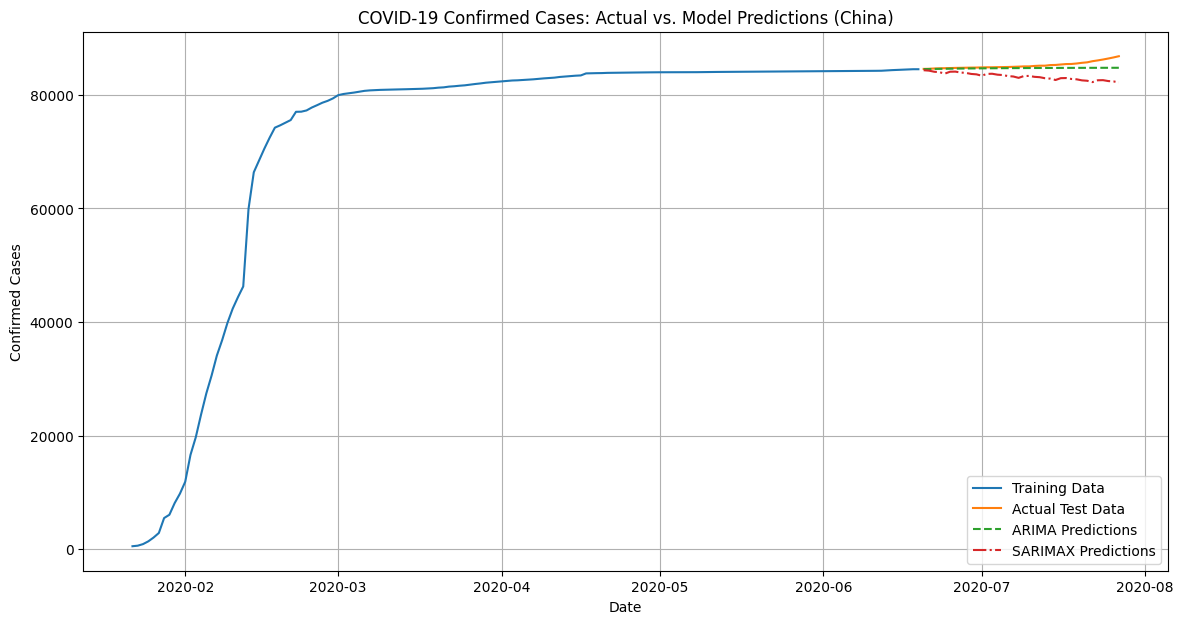

In [ ]:
    plt.figure(figsize=(14, 7))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(test_data.index, arima_test_predictions, label='ARIMA Predictions', linestyle='--')
    plt.plot(test_data.index, sarimax_test_predictions, label='SARIMAX Predictions', linestyle='-.')
    plt.title('COVID-19 Confirmed Cases: Actual vs. Model Predictions (China)')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.grid(True)
    plt.show()


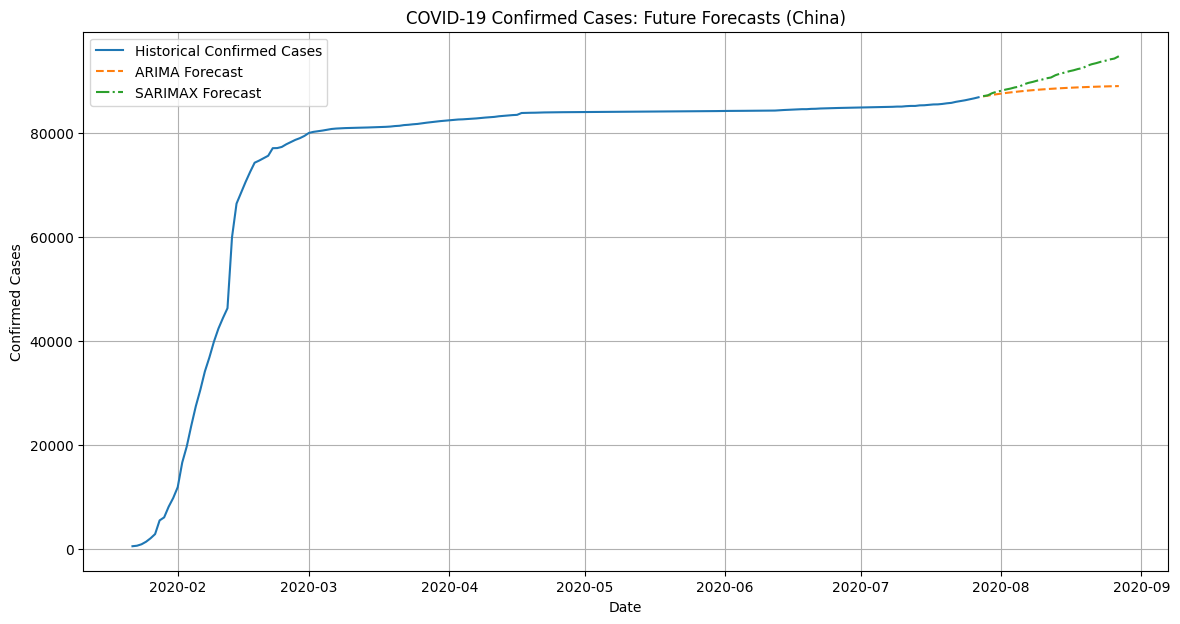

In [ ]:
    plt.figure(figsize=(14, 7))
    plt.plot(china_df['Confirmed'], label='Historical Confirmed Cases')
    plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
    plt.plot(sarimax_forecast.index, sarimax_forecast, label='SARIMAX Forecast', linestyle='-.')
    plt.title('COVID-19 Confirmed Cases: Future Forecasts (China)')
    plt.xlabel('Date')
    plt.ylabel('Confirmed Cases')
    plt.legend()
    plt.grid(True)
    plt.show()